电离层校正的东西不是完全没写，只是不算完善。

In [1]:
import sys
sys.path.append("..")
import os
os.chdir("..")
from functions.image import wgs2ecs, ecs2wgs, TX
from functions.trans import cos_vectors, doy
from functions.dem import wgs2utm, utm2wgs
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import ionex

class Ion(object):
    def __init__(self, path) -> None:
        self.data = np.empty((12, 71, 73))
        with open(path, "r") as file:
            ionex_map = list(ionex.reader(file))
            for i in range(12):
                self.data[i] = np.reshape(ionex_map[i+1].tec, self.data.shape[1:])            

    def find(self, sod, lon, lat):
        i = np.int32(sod / 7200)
        j = np.int32((87.5 - lat) / 2.5)
        k = np.int32((lon + 180) / 5)
        return self.data[i, j, k]

    def cal_delay(self, sod, sp, lon, lat, h, f):
        height = 450e3
        tp = wgs2ecs(lon, lat, h)
        cos_zenith = cos_vectors(tp, sp - tp)
        length = height / cos_zenith
        dp = sp - tp
        pierces = dp * length / np.linalg.norm(dp, axis=0) + tp

        plon, plat, _ = ecs2wgs(pierces[0], pierces[1], pierces[2])
        tec = self.find(sod, plon, plat)
        return 40.3e16 * tec / (f**2*cos_vectors(pierces, sp-wgs2ecs(lon, lat, h)))

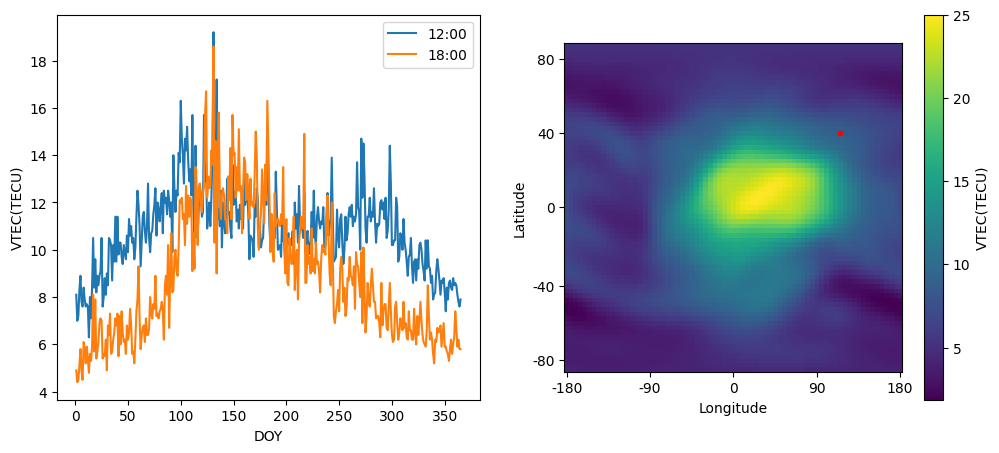

In [2]:

data = np.empty((365, 12, 71, 73))
for i, path in enumerate(sorted(glob("data/ionex/*"))):
    data[i] = Ion(path).data
noon = data[:, int((12 - 8) / 2), 19, 59]
dusk = data[:, int((18 - 8) / 2), 19, 59]
mean = np.mean(data[:, int((18 - 8) / 2)], axis=0)
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
# plt.plot(range(1,366), dawn, label="6:00")
plt.plot(range(1,366), noon, label="12:00")#,c="black", linestyle="dashed")
plt.plot(range(1,366), dusk, label="18:00")#,c="black", linestyle="solid")
plt.xlabel("DOY")
plt.ylabel("VTEC(TECU)")
plt.legend()
plt.subplot(1,2,2)
plt.imshow(mean)
plt.colorbar().set_label("VTEC(TECU)")
plt.scatter((59,),(19,),c="red",marker=".")
plt.xticks([0,18, 36, 54, 72],["-180", "-90", "0", "90", "180"])
plt.yticks([3,19, 35, 52, 68],["80", "40", "0", "-40", "-80"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

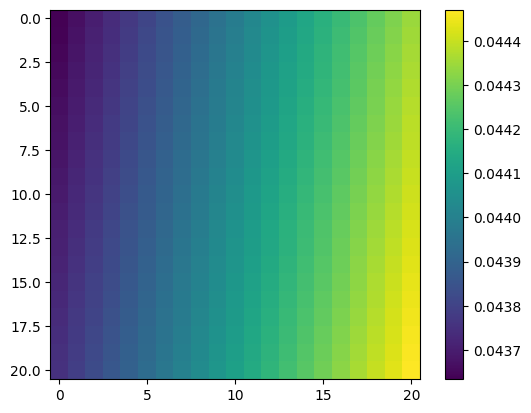

In [3]:
def get_tx_paths():
    xml_paths = glob(
        "data/TerraSAR-X/*/TSX-1.SAR.L1B/*/*SAR__SSC*.xml")
    res = {}
    for i in xml_paths:
        filename = i.split("/")[-1][:-4]
        res[filename[28:36]] = ((i, glob(
            "data/TerraSAR-X/*/TSX-1.SAR.L1B/%s/IMAGEDATA/*.cos" % filename)[0]))
    return res
sDay = "20190117"
xml_path, cos_path = get_tx_paths()[sDay]
tx = TX(xml_path, cos_path)
lon, lat, h = 116.2750925, 40.2527227, 122.8
# lon, lat, h = 116.2197997, 40.2121041, 56.4
x, y = wgs2utm(lon, lat)
extent = np.arange(-10e3, 10e3+1, 1e3)
xs, ys = np.meshgrid(extent+x, extent+y)
lon, lat = utm2wgs(xs, ys)
gen = tx.indirect_with_offset(lon, lat, h)
sp = gen.send(None)
ion = Ion(glob("data/ionex/igsg%03d0.*" % doy(sDay))[0])

res = ion.cal_delay(tx.par['start_time'], sp, lon, lat, h, 9.65e9)
plt.imshow(res)
plt.colorbar()
plt.show()


电离层数据除了从[cddis网站](https://cddis.nasa.gov/archive/gnss/products/ionex/)下载外，还可以从[jpl](https://sideshow.jpl.nasa.gov/pub/iono_daily/gim_for_research/)下载。jpl的数据具有较高的分辨率。jpl的两种数据jpli和jpld的区别可见[论文](https://link.springer.com/article/10.1007/s00190-024-01860-3)。


/tmp/ipykernel_13717/2146156994.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  self.data = np.array(data['tecmap'])


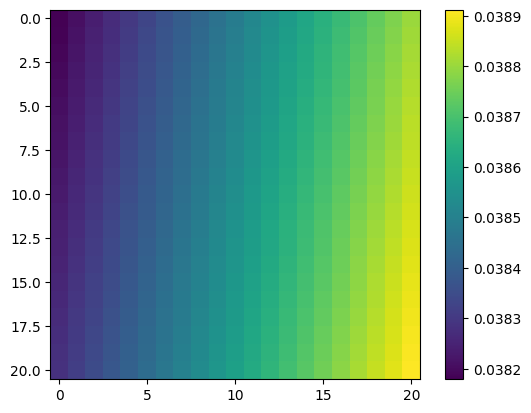

In [5]:

from netCDF4 import Dataset

class Jpld(Ion):
    def __init__(self, path) -> None:
        data = Dataset(path)
        self.data = np.array(data['tecmap'])

    def find(self, sod, lon, lat):
        i = np.int32(sod // 900)
        j = np.int32(90 - lat)
        k = np.int32(lon + 180)
        return self.data[i, j, k]

jpld = Jpld(glob("data/jpld/jpld%03d0.*" % doy(sDay))[0])
res = jpld.cal_delay(tx.par['start_time'], sp, lon, lat, h, 9.65e9)
plt.imshow(res)
plt.colorbar()
plt.show()